In [1]:
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt

In [2]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: fsi-select-demo


# Data on Power Production

Query BQ to get a current profile of power generation.  Compliments of EIA.

In [3]:
query = """
   SELECT date, state, type, value as KMegawatts 
   FROM `fsi-select-demo.us_eia.electricity_generation`
   where date = '2021-03-01'"""  
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query
productionDF = query_job.to_dataframe()

<AxesSubplot:ylabel='type'>

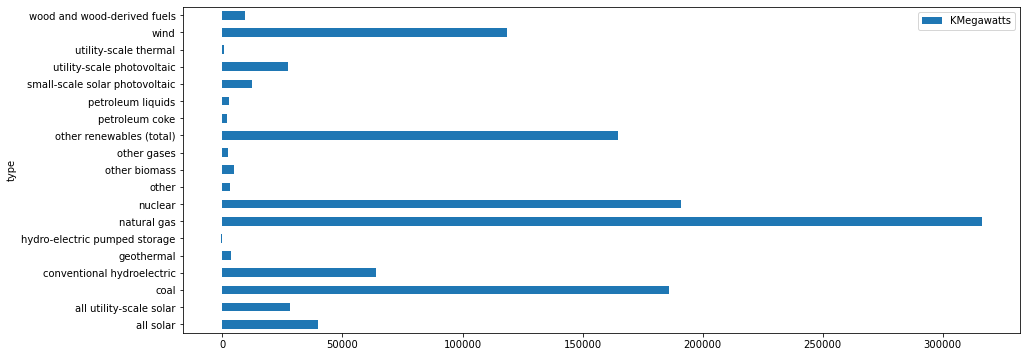

In [4]:
productionDF.loc[productionDF['type']!='all fuels'].groupby(by=['type']).sum().plot(kind='barh',figsize=(15,6), legend=True)

In [5]:
# Get All Data 

In [56]:
query = """
   SELECT date, state, type, value as KMegawatts 
   FROM `fsi-select-demo.us_eia.electricity_generation`
   """  
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query
productionDF = query_job.to_dataframe()
productionDF.set_index('date', inplace=True)

In [58]:
# Group Relevent Power Types into Clean versus Dirty (What does that really mean?)  
# This is my definition of 'clean', consider there are combinations of this fact depending upon audiance.

powerClassTypes = {
    'coal': 'Dirty', 
    'wind': 'Clean', 
    'other': 'Dirty', 
    'nuclear': 'Dirty',
    'all fuels': None,
    'all solar': None,
    'geothermal': 'Clean', 
    'natural gas': 'Dirty', 
    'other gases': 'Dirty', 
    'other biomass': 'Dirty',
    'petroleum coke': 'Dirty', 
    'petroleum liquids': 'Dirty', 
    'all utility-scale solar': None,
    'utility-scale thermal': 'Clean', 
    'other renewables (total)': None,
    'conventional hydroelectric': 'Clean',
    'utility-scale photovoltaic': 'Clean',
    'wood and wood-derived fuels': 'Dirty',
    'small-scale solar photovoltaic': 'Clean',
    'hydro-electric pumped storage': 'Clean',    
}

#Map PowerClassTypes to raw data
productionDF['type_class'] = productionDF['type'].map( powerClassTypes)


In [59]:
productionDF['type_class'] = productionDF['type'].map( powerClassTypes)


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

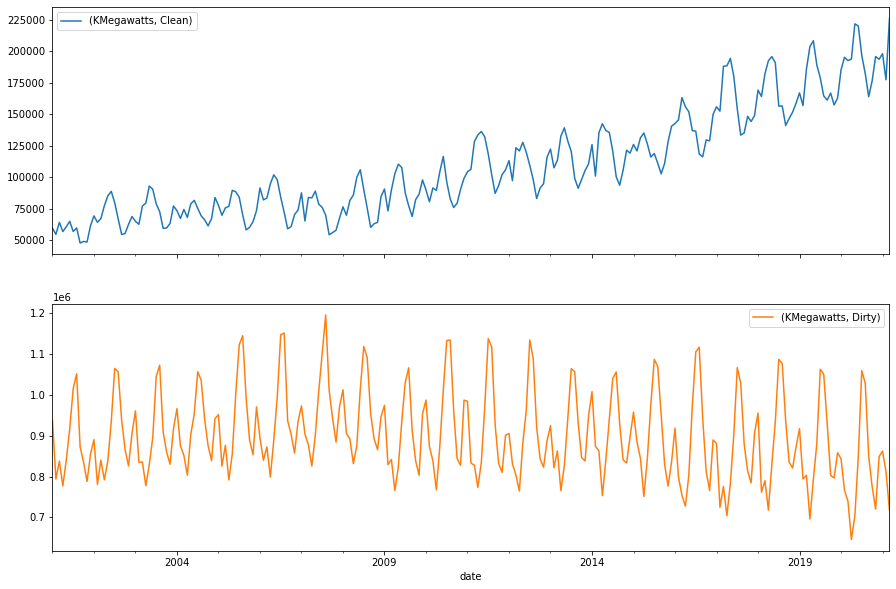

In [60]:
productionDF.reset_index().groupby(by=['date','type_class']).sum().reset_index().set_index('date').pivot(columns='type_class').plot(subplots=True, figsize=(15,10))

# Generate some Average Ratios to use for Indexing Purposes


In [61]:
baselineRatioAllStatesDF = productionDF.reset_index().groupby(by=['date','type_class']).sum().reset_index().set_index('date').pivot(columns='type_class')
baselineRatioAllStatesDF = baselineRatioAllStatesDF['KMegawatts']

In [62]:
baselineRatioAllStatesDF.head()

type_class,Clean,Dirty
date,,
2001-01-01 00:00:00+00:00,59645.993,937813.99304
2001-02-01 00:00:00+00:00,54810.663,793972.22902
2001-03-01 00:00:00+00:00,64277.963,837747.17702
2001-04-01 00:00:00+00:00,56990.297,777130.03500
2001-05-01 00:00:00+00:00,60778.554,840453.15404


In [63]:
#Create CleanPercentageRawMonth
baselineRatioAllStatesDF['CleanPercentageRawMonth'] = (baselineRatioAllStatesDF['Clean'] / (baselineRatioAllStatesDF['Clean'] + baselineRatioAllStatesDF['Dirty']))*100



array([<AxesSubplot:xlabel='date'>], dtype=object)

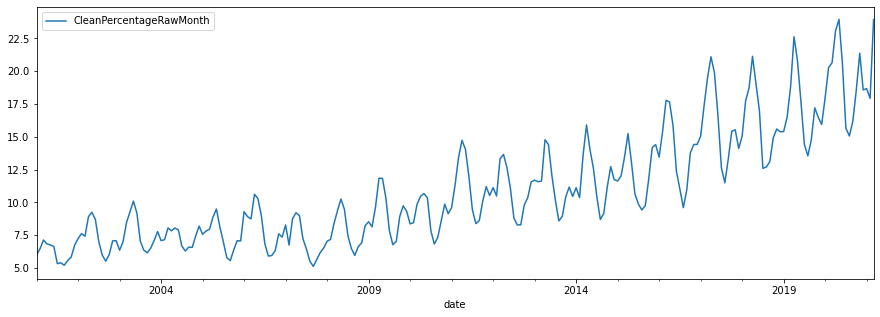

In [64]:
baselineRatioAllStatesDF['CleanPercentageRawMonth'].plot(subplots=True, figsize=(15,5), legend=True)


<AxesSubplot:xlabel='date'>

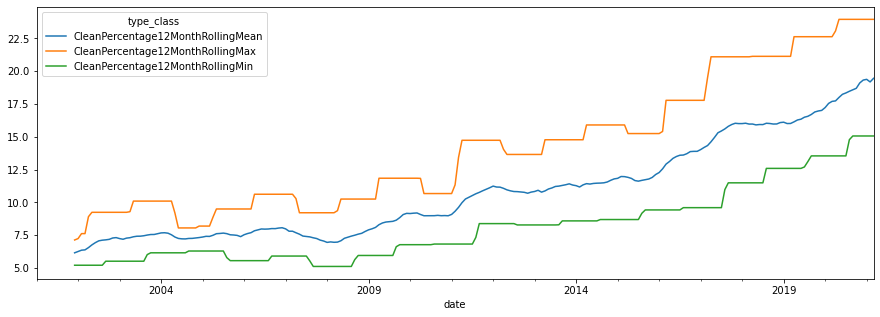

In [65]:
baselineRatioAllStatesDF['CleanPercentage12MonthRollingMean'] = baselineRatioAllStatesDF['CleanPercentageRawMonth'].rolling(12).mean()
baselineRatioAllStatesDF['CleanPercentage12MonthRollingMax'] = baselineRatioAllStatesDF['CleanPercentageRawMonth'].rolling(12).max()
baselineRatioAllStatesDF['CleanPercentage12MonthRollingMin'] = baselineRatioAllStatesDF['CleanPercentageRawMonth'].rolling(12).min()
#pd.Series.rolling baselineRatioAllStatesDF['CleanPercentage'], 12)
baselineRatioAllStatesDF[['CleanPercentage12MonthRollingMean','CleanPercentage12MonthRollingMax','CleanPercentage12MonthRollingMin']].plot( figsize=(15,5), legend=True)

In [66]:
baselineRatioAllStatesDF.tail()

type_class,Clean,Dirty,CleanPercentageRawMonth,CleanPercentage12MonthRollingMean,CleanPercentage12MonthRollingMax,CleanPercentage12MonthRollingMin
date,,,,,,
2020-11-01 00:00:00+00:00,195812.12407,720270.27169,21.374947,19.106248,23.959238,15.061373
2020-12-01 00:00:00+00:00,193603.79631,848711.86467,18.574392,19.325714,23.959238,15.061373
2021-01-01 00:00:00+00:00,198048.33308,862394.01754,18.676011,19.382449,23.959238,15.061373
2021-02-01 00:00:00+00:00,177363.62428,812083.80750,17.925523,19.185169,23.959238,15.061373
2021-03-01 00:00:00+00:00,226013.25296,718063.36882,23.940139,19.459451,23.959238,15.061373


# States Performances 

In [67]:
#

In [109]:
stateResults = {}

for state in productionDF['state'].unique():
    #print (state,)
    
    tempDF = productionDF.loc[productionDF['state']==state]
    tempStateDF = tempDF.reset_index().groupby(by=['date','type_class']).sum().reset_index().set_index('date').pivot(columns=['type_class'])
    tempStateDF = tempStateDF['KMegawatts']
    tempStateDF['CleanPercentageRawMonth'] = (tempStateDF['Clean'] / (tempStateDF['Clean'] + tempStateDF['Dirty']))*100

    #columns = ['CleanPercentageRawMonth']
    #tempStateDF = tempStateDF[[columns]]
    tempStateDF.rename(columns={'CleanPercentageRawMonth':state +'_CleanPercentageRawMonth'}, inplace=True)
    tempStateDF = tempStateDF[[state+'_CleanPercentageRawMonth']]

    tempStateDF = pd.merge(baselineRatioAllStatesDF[['CleanPercentageRawMonth']],tempStateDF, right_index=True, left_index=True)
    tempStateDF[state +'_NationalCompPercentage'] = (tempStateDF[state+'_CleanPercentageRawMonth'] - tempStateDF['CleanPercentageRawMonth']) / tempStateDF['CleanPercentageRawMonth'] * 100
    tempStateDF = tempStateDF[[state+'_CleanPercentageRawMonth', state +'_NationalCompPercentage',]]

    stateResults[state] = tempStateDF

In [124]:
#Combine State Percentages into single frame and plot

try:
    del combinedStateRatiosDF
    del combinedStatePerformanceDF
except: 
    pass
for state in stateResults:
    #print (state)
    try:
        combinedStateRatiosDF = pd.merge(combinedStateRatiosDF, stateResults[state][[state+'_CleanPercentageRawMonth']], left_index=True, right_index=True)
        combinedStatePerformanceDF = pd.merge(combinedStatePerformanceDF, stateResults[state][[state+'_NationalCompPercentage']], left_index=True, right_index=True)
    
        
    except:
        combinedStateRatiosDF = stateResults[state][[state+'_CleanPercentageRawMonth']].copy()
        combinedStatePerformanceDF = stateResults[state][[state+'_NationalCompPercentage']].copy()
    


In [125]:
combinedStateRatiosDF.tail()

type_class,Iowa_CleanPercentageRawMonth,Ohio_CleanPercentageRawMonth,Utah_CleanPercentageRawMonth,Idaho_CleanPercentageRawMonth,Maine_CleanPercentageRawMonth,Texas_CleanPercentageRawMonth,Alaska_CleanPercentageRawMonth,Hawaii_CleanPercentageRawMonth,Kansas_CleanPercentageRawMonth,Nevada_CleanPercentageRawMonth,...,New England (total)_CleanPercentageRawMonth,South Atlantic (total)_CleanPercentageRawMonth,Middle Atlantic (total)_CleanPercentageRawMonth,District Of Columbia_CleanPercentageRawMonth,East North Central (total)_CleanPercentageRawMonth,East South Central (total)_CleanPercentageRawMonth,Pacific Contiguous (total)_CleanPercentageRawMonth,West North Central (total)_CleanPercentageRawMonth,West South Central (total)_CleanPercentageRawMonth,Pacific Noncontiguous (total)_CleanPercentageRawMonth
date,,,,,,,,,,,,,,,,,,,,,
2020-11-01 00:00:00+00:00,82.448343,3.080495,11.707337,77.760027,68.236440,25.970349,37.205716,20.728595,50.976240,35.092800,...,17.671864,5.831267,13.080984,34.206825,10.168362,9.173152,54.906831,44.387421,24.481659,26.674591
2020-12-01 00:00:00+00:00,60.478752,2.740924,9.475059,74.313930,59.410958,24.726519,32.888108,20.009980,43.151959,27.300587,...,15.716942,5.333245,11.242880,30.497797,8.133823,7.905285,50.976766,36.276032,22.352205,25.122984
2021-01-01 00:00:00+00:00,57.997472,2.252194,11.814712,78.423906,57.303092,23.057403,39.645722,22.131728,45.429069,27.922242,...,15.086107,5.535627,10.475406,32.578552,7.195316,7.288399,57.429395,36.431464,21.408037,29.095394
2021-02-01 00:00:00+00:00,56.709214,2.881396,12.367306,74.957703,51.333303,20.664280,34.883874,23.042087,32.671200,33.896511,...,14.573436,5.443167,10.099804,38.479726,7.884794,7.086035,59.939100,31.742648,18.782578,28.215774
2021-03-01 00:00:00+00:00,74.001278,3.940170,16.048486,72.935765,64.250649,35.403057,31.590580,26.366200,53.455302,34.632141,...,20.250792,8.436668,13.267251,42.758166,11.369480,9.271380,57.786477,47.302806,32.086135,28.167231


In [127]:
combinedStatePerformanceDF.tail()

type_class,Iowa_NationalCompPercentage,Ohio_NationalCompPercentage,Utah_NationalCompPercentage,Idaho_NationalCompPercentage,Maine_NationalCompPercentage,Texas_NationalCompPercentage,Alaska_NationalCompPercentage,Hawaii_NationalCompPercentage,Kansas_NationalCompPercentage,Nevada_NationalCompPercentage,...,New England (total)_NationalCompPercentage,South Atlantic (total)_NationalCompPercentage,Middle Atlantic (total)_NationalCompPercentage,District Of Columbia_NationalCompPercentage,East North Central (total)_NationalCompPercentage,East South Central (total)_NationalCompPercentage,Pacific Contiguous (total)_NationalCompPercentage,West North Central (total)_NationalCompPercentage,West South Central (total)_NationalCompPercentage,Pacific Noncontiguous (total)_NationalCompPercentage
date,,,,,,,,,,,,,,,,,,,,,
2020-11-01 00:00:00+00:00,285.724205,-85.588293,-45.228695,263.790504,219.235605,21.499013,74.062263,-3.023876,138.485928,64.177251,...,-17.324408,-72.719151,-38.802263,60.032327,-52.428598,-57.084561,156.874703,107.660965,14.534362,24.793721
2020-12-01 00:00:00+00:00,225.602865,-85.243533,-48.988591,300.088092,219.854122,33.121555,77.061558,7.728858,132.319633,46.979705,...,-15.383813,-71.287107,-39.471072,64.192707,-56.209479,-57.439870,174.446484,95.301316,20.338826,35.256025
2021-01-01 00:00:00+00:00,210.545283,-87.940712,-36.738569,319.917854,206.827249,23.459998,112.281530,18.503503,143.248240,49.508593,...,-19.222010,-70.359693,-43.909832,74.440630,-61.472952,-60.974543,207.503533,95.070904,14.628530,55.790193
2021-02-01 00:00:00+00:00,216.360171,-83.925733,-31.007280,318.161884,186.369910,15.278537,94.604502,28.543457,82.260791,89.096360,...,-18.700078,-69.634541,-43.656849,114.664455,-56.013587,-60.469577,234.378534,77.080740,4.781203,57.405586
2021-03-01 00:00:00+00:00,209.109644,-83.541573,-32.964105,204.658906,168.380439,47.881588,31.956547,10.133867,123.287352,44.661404,...,-15.410717,-64.759317,-44.581562,78.604506,-52.508715,-61.272657,141.379040,97.587851,34.026523,17.656926


In [130]:
combinedStatePerformanceDF.rolling(12).mean().tail()

type_class,Iowa_NationalCompPercentage,Ohio_NationalCompPercentage,Utah_NationalCompPercentage,Idaho_NationalCompPercentage,Maine_NationalCompPercentage,Texas_NationalCompPercentage,Alaska_NationalCompPercentage,Hawaii_NationalCompPercentage,Kansas_NationalCompPercentage,Nevada_NationalCompPercentage,...,New England (total)_NationalCompPercentage,South Atlantic (total)_NationalCompPercentage,Middle Atlantic (total)_NationalCompPercentage,District Of Columbia_NationalCompPercentage,East North Central (total)_NationalCompPercentage,East South Central (total)_NationalCompPercentage,Pacific Contiguous (total)_NationalCompPercentage,West North Central (total)_NationalCompPercentage,West South Central (total)_NationalCompPercentage,Pacific Noncontiguous (total)_NationalCompPercentage
date,,,,,,,,,,,,,,,,,,,,,
2020-11-01 00:00:00+00:00,209.852757,-85.861701,-27.177785,298.132858,215.398193,14.593849,70.633289,20.884160,131.017982,58.401602,...,-7.404938,-69.071444,-36.574004,116.018376,-60.161299,-57.007687,197.417130,86.495644,5.797431,41.393571
2020-12-01 00:00:00+00:00,210.146548,-86.046174,-26.492471,299.900058,209.121136,15.055885,71.675577,20.604825,127.375379,59.146029,...,-8.566280,-69.052148,-37.257131,114.884414,-60.774707,-57.477699,197.231613,86.619745,6.007690,41.756353
2021-01-01 00:00:00+00:00,212.208156,-86.184797,-25.897119,302.043180,206.690162,14.669145,75.314665,21.950382,127.389797,59.758017,...,-8.725813,-69.082014,-37.717505,116.753309,-60.826492,-58.161845,198.086377,88.311159,5.695721,43.791977
2021-02-01 00:00:00+00:00,215.406121,-86.039564,-25.727188,305.941500,204.204356,14.654806,76.776404,23.746555,123.495416,62.497329,...,-8.953441,-69.137162,-38.060432,122.004316,-60.674077,-58.476782,201.208796,88.129659,5.425515,45.492309
2021-03-01 00:00:00+00:00,212.702963,-86.035975,-26.751818,301.303274,199.435175,17.281452,75.204907,23.301484,122.605598,62.123921,...,-10.298304,-69.092012,-38.884623,120.708148,-60.367145,-59.407730,199.332531,88.613344,7.707154,44.585487


# ESG Code

